In [2]:
# Read New Mexico county graph from the json file "NM_county.json"
from gerrychain import Graph
filepath = 'C:\\Users\\colle\\Downloads\\'
filename = 'NM_county.json'

G = Graph.from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center

In [3]:
from geopy.distance import geodesic

# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [4]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 702312 and U = 709369 and k = 3


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create x[i,j] variable which equals one when county i 
#    is assigned to (the district centered at) county j
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-18


In [6]:
# objective is to minimize the moment of inertia: sum (d^2 * p * x over all i and j)
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [8]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from souce/root v
f = m.addVars( DG.edges, G.nodes ) 

# add constraints saying that if node i is assigned to node j, 
#   then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can receive flow of type j 
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [9]:
# solve, making sure to set a 0.00% MIP gap tolerance
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3334 rows, 6237 columns and 22656 nonzeros
Model fingerprint: 0x89d8f0ce
Variable types: 5148 continuous, 1089 integer (1089 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [2e+06, 4e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 203 rows and 581 columns
Presolve time: 0.10s
Presolved: 3131 rows, 5656 columns, 21108 nonzeros
Variable types: 4603 continuous, 1053 integer (1053 binary)

Root relaxation: objective 1.217797e+10, 622 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds  

In [10]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

12654737015.702263
District 0 has population 707195 and contains counties ['Bernalillo', 'Catron', 'Cibola']

District 1 has population 705274 and contains counties ['Curry', 'Roosevelt', 'Lincoln', 'Guadalupe', 'Luna', 'Lea', 'Chaves', 'Quay', 'Sierra', 'De Baca', 'Otero', 'San Miguel', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']

District 2 has population 705053 and contains counties ['San Juan', 'Torrance', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Valencia', 'Union', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']



In [11]:
# Let's draw it on a map
import geopandas as gpd

In [13]:
# Read New Mexico county shapefile from "NM_county.shp"
filepath = 'C:\\Users\\colle\\Downloads\\'
filename = 'NM_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

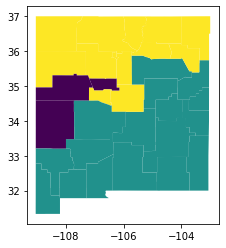

In [14]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()